In [88]:
import numpy as np
import os
import pylab as plt
import elephant
import matplotlib as mlib
%matplotlib inline

In [89]:
# ensure we use viridis as the default cmap
plt.viridis()

# ensure we use the same rc parameters for all matplotlib outputs
mlib.rcParams.update({'font.size': 24})
mlib.rcParams.update({'errorbar.capsize': 5})
mlib.rcParams.update({'figure.autolayout': True})
viridis_cmap = mlib.cm.get_cmap('viridis')

<Figure size 432x288 with 0 Axes>

This is how the compute error in the code on the NRP. Makes little sense to me but whatever.

In [2]:
def compute_P_error(kp, head_position, eye_position):
    error = kp * (head_position + eye_position)
    return error
def compute_D_error(kd, head_velocity, eye_velocity):
    error = kd * (head_velocity + eye_velocity)
    return error

They originally use kp and kd values of 15 and a "max amplitude" of 0.8. I got rid of all of these random values and I've tried to normalise everything between 0 and 1.

In [122]:
# Some sort of scaling factors?
# kp=15.0
# kd=15.0
kp=1.0
kd=1.0
MAX_AMPLITUDE = 0.8  # Not used

Loading pre-computed head positions and velocities for an entire experiment. In actuality, only the first 1000 samples are of interest here. These get repeated for the number of trials required for the full experiment. 

In [123]:
# Base dir
base_dir = "/localhome/mbax3pb2/anaconda3/envs/icub_vor_spinnaker/spinnaker/sPyNNaker8/p8_integration_tests/icub_vor/"
head_pos = np.loadtxt(os.path.join(base_dir, "normalised_head_positions.csv"))
head_vel = np.loadtxt(os.path.join(base_dir, "normalised_head_velocities.csv"))

Making eye velocity and position be out of phase. These represent "perfection" for this experiment.

In [125]:
perfect_eye_vel = np.concatenate((head_vel[500:], head_vel[:500]))
perfect_eye_pos = np.concatenate((head_pos[500:], head_pos[:500]))

In [126]:
print(head_pos.size)
print(head_vel.size)
print(perfect_eye_vel.size)
print(perfect_eye_pos.size)

1000000
1000000
1000000
1000000


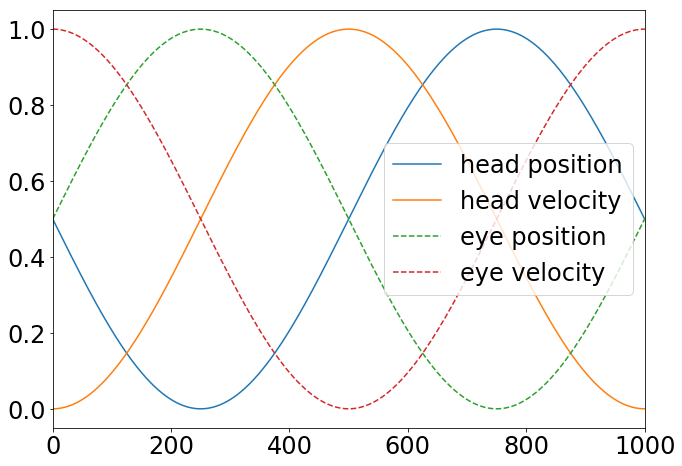

In [127]:
plt.figure(figsize=(10, 7))
plt.plot(head_pos, label="head position")
plt.plot(head_vel, label="head velocity")
plt.plot(perfect_eye_pos, label="eye position", ls='--')
plt.plot(perfect_eye_vel, label="eye velocity", ls='--')
plt.legend(loc="best")
plt.xlim([0, 1000])
plt.show()

In [134]:
current_time = 0

# Error computation and rate setting

https://github.com/EduardoRosLab/VOR_in_neurorobotics/blob/master/error_activity.py

I assume that the error is meant to be in the range [-1, +1] because it is multiplied by 100 to get some sort of neuron ID. 

Does this mean that if the error has magnitude 1, the eye position / velocity combo is maximally bad, thus all CF should be active? So the maximum error is encoded as a high water mark in CF neuron space?

In [202]:
# These are my modified error definitions -- NOTE the minus signs
def compute_P_error(head_position, eye_position):
    return head_position - eye_position
def compute_D_error(head_velocity, eye_velocity):
    return head_velocity - eye_velocity

In [206]:
position_error = compute_P_error(head_pos[current_time+500], perfect_eye_pos[current_time+500])
print("Position error", position_error)

velocity_error = compute_D_error(head_vel[current_time+500], perfect_eye_vel[current_time+500])
print("Velocity error", position_error)

# error=(position_error * 0.1 + (velocity_error/(2.0*3.141592)) * 0.9)/MAX_AMPLITUDE
error = position_error + velocity_error

print("error", error)


Position error -1.6653345369377348e-16
Velocity error -1.6653345369377348e-16
error 0.9999999999999998


(-1.1, 1.1)

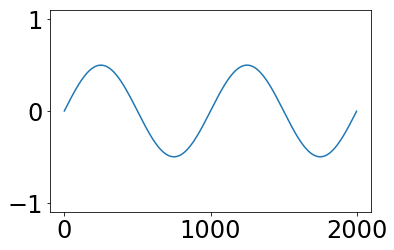

In [220]:
errs = []
for ct in range(2000):
    p_e = compute_P_error(head_pos[ct+500], perfect_eye_pos[0])
    v_e = compute_D_error(head_vel[ct+500], perfect_eye_vel[ct])
    e = p_e + v_e
    errs.append(e)
    
plt.plot(errs)
plt.ylim([-1.1, 1.1])

(-1.1, 1.1)

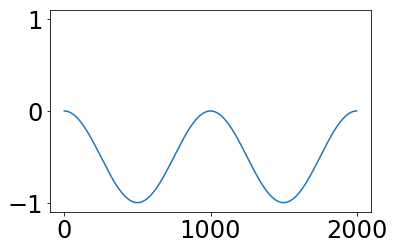

In [219]:
errs = []
for ct in range(2000):
    p_e = compute_P_error(head_pos[ct+500], perfect_eye_pos[ct])
    v_e = compute_D_error(head_vel[ct+500], perfect_eye_vel[0])
    e = p_e + v_e
    errs.append(e)
    
plt.plot(errs)
plt.ylim([-1.1, 1.1])

(-1.1, 1.1)

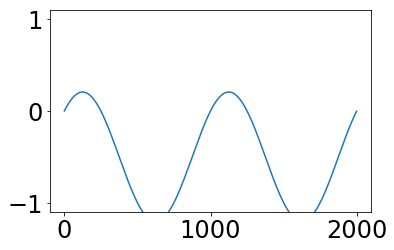

In [218]:
errs = []
for ct in range(2000):
    p_e = compute_P_error(head_pos[ct+500], perfect_eye_pos[0])
    v_e = compute_D_error(head_vel[ct+500], perfect_eye_vel[0])
    e = p_e + v_e
    errs.append(e)
    
plt.plot(errs)
plt.ylim([-1.1, 1.1])

Errors with a magnitude higher than 1 produce a kink in the response of CF (see below)

In [228]:
error=1.5  # 0.3 0.5 0.1 -0.5

In [229]:
min_rate = 2.0
max_rate = 20.0
low_neuron_ID_threshold = abs(error) * 100.0
up_neuron_ID_threshold = low_neuron_ID_threshold - 100.0
IO_antagonist_activity = np.zeros(100)
IO_agonist_activity = np.zeros(100)


print(low_neuron_ID_threshold)
print(up_neuron_ID_threshold)
rate = []
for i in range (100):
    if(i < up_neuron_ID_threshold):
        rate.append(max_rate)
    elif(i<low_neuron_ID_threshold):
        aux_rate=max_rate - (max_rate-min_rate)*((i - up_neuron_ID_threshold)/(low_neuron_ID_threshold - up_neuron_ID_threshold))
        rate.append(aux_rate)
    else:
        rate.append(min_rate)
if error>=0.0:
    IO_agonist_activity[:]=min_rate
    IO_antagonist_activity[:]=rate
else:
    IO_antagonist_activity[:]=min_rate
    IO_agonist_activity[:]=rate

150.0
50.0


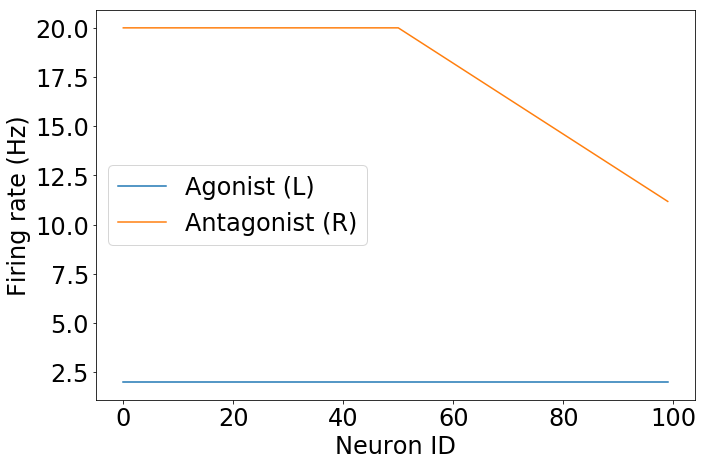

In [230]:
plt.figure(figsize=(10, 7))
plt.plot(IO_agonist_activity, label="Agonist (L)")
plt.plot(IO_antagonist_activity, label="Antagonist (R)")
plt.xlabel("Neuron ID")
plt.ylabel("Firing rate (Hz)")
plt.legend(loc="best")
plt.show()

In [224]:
np.sum(IO_antagonist_activity) / 100.

12.791000000000002

In [86]:
IO_agonist_activity

array([11.  , 10.82, 10.64, 10.46, 10.28, 10.1 ,  9.92,  9.74,  9.56,
        9.38,  9.2 ,  9.02,  8.84,  8.66,  8.48,  8.3 ,  8.12,  7.94,
        7.76,  7.58,  7.4 ,  7.22,  7.04,  6.86,  6.68,  6.5 ,  6.32,
        6.14,  5.96,  5.78,  5.6 ,  5.42,  5.24,  5.06,  4.88,  4.7 ,
        4.52,  4.34,  4.16,  3.98,  3.8 ,  3.62,  3.44,  3.26,  3.08,
        2.9 ,  2.72,  2.54,  2.36,  2.18,  2.  ,  2.  ,  2.  ,  2.  ,
        2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,
        2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,
        2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,
        2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,
        2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,
        2.  ])

In [71]:
IO_antagonist_activity

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])